<a href="https://colab.research.google.com/github/kelvindatascientist/neural_network_training/blob/main/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shallow Neural Networks for Unit Operation Modelling

In this example a NN was trained with multioutput.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May 19 23:26:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q -U keras-tuner==1.1.1

In [ ]:
!pip install -q -U tensorflow==2.8.0

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from numpy import sqrt
from keras_tuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
import joblib
import csv
from numpy.random import seed
seed(1)

In [ ]:
tf.__version__

'2.8.0'

## Retrieve data from fenomenological model

In [ ]:
nome_da_corrida = 'E47949L'

In [ ]:
df = pd.read_excel("/content/drive/My Drive/ann4a/00_Database/dataset5.xlsx")

df = df.drop_duplicates()
df = df.reset_index(drop=True)
df =df.dropna()

dataset = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250 entries, 0 to 250
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   H2_ANN4          250 non-null    float64
 1   METHANOL_ANN4    250 non-null    float64
 2   ACETIC_ANN4      250 non-null    float64
 3   CO2_ANN4         250 non-null    float64
 4   WATER_ANN4       250 non-null    float64
 5   CH4_ANN4         250 non-null    float64
 6   METHY-01_ANN4    250 non-null    float64
 7   ETHYL-01_ANN4    250 non-null    float64
 8   ETHAN-01_ANN4    250 non-null    float64
 9   SOLVENT_ANN4     250 non-null    float64
 10  T_501_ANN4       250 non-null    float64
 11  P_501_ANN4       250 non-null    float64
 12  T_HT-09_ANN4     250 non-null    float64
 13  RR1_ANN4         250 non-null    float64
 14  D/F1_ANN4        250 non-null    float64
 15  FEEDSTAGE1_ANN4  250 non-null    float64
 16  flow_ACETIC_S1   250 non-null    float64
 17  flow_SOLVENT_S1 

## Extracting data

The data were alocated accordingly, inputs (X) and outputs/targets (y).

In [ ]:
number_of_input_variables = 16
print('There are ' + str(number_of_input_variables) + ' variables in the input:')
print(dataset.columns.to_list()[0:number_of_input_variables])

There are 16 variables in the input:
['H2_ANN4', 'METHANOL_ANN4', 'ACETIC_ANN4', 'CO2_ANN4', 'WATER_ANN4', 'CH4_ANN4', 'METHY-01_ANN4', 'ETHYL-01_ANN4', 'ETHAN-01_ANN4', 'SOLVENT_ANN4', 'T_501_ANN4', 'P_501_ANN4', 'T_HT-09_ANN4', 'RR1_ANN4', 'D/F1_ANN4', 'FEEDSTAGE1_ANN4']


In [ ]:
print('There are ' + str(dataset.shape[1] - number_of_input_variables) + ' variables in the output:')
print(dataset.columns.to_list()[number_of_input_variables:])

There are 11 variables in the output:
['flow_ACETIC_S1', 'flow_SOLVENT_S1', 'T_S1', 'flow_ACETIC_503', 'flow_WATER_503', 'T_503', 'CBM_total', 'CBM0_total', 'Cold_utility', 'Hot_utility', 'CO2_eq']


In [ ]:
colunas = dataset.columns
input_features = colunas[0:number_of_input_variables]
output_features = colunas[number_of_input_variables:]

## Train Test split

In [ ]:
len(dataset.values[:,number_of_input_variables:][0])

11

In [ ]:
X, y = dataset.values[:, 0:number_of_input_variables], dataset.values[:,number_of_input_variables:]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=102)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(212, 16) (38, 16) (212, 11) (38, 11)


In [ ]:
pd.set_option('display.float_format', str)
pd.DataFrame(X_train).describe().transpose().drop(['count', '25%', '50%', '75%'], axis=1)

,mean,std,min,max
0,5.0467848576466835e-05,2.6055412717997667e-05,6.70250926547522e-06,9.75492948997239e-05
1,0.006479191628847142,0.0019412097093126064,0.00301612256978581,0.00996787238108594
2,400.0246906462021,28.239508893321315,318.264142949283,429.32504564351
3,209.92866714299845,63.56481427569077,69.9051903034454,307.380461181466
4,409.9319804670412,45.29327479545349,310.899914379864,479.143167677886
5,22.511268791853233,11.436332855744967,3.85523027097609,48.5975040824907
6,0.006023417447566209,0.002260555495859908,0.00206736547035272,0.00993665549990168
7,0.0025111605731637644,0.0007785935002092232,0.0010676221197313,0.00387170279471638
8,0.000598657432912486,0.00016757710097515025,0.000304760018486774,0.000892553790295191
9,778.4551082776652,1.9609667141965965,775.33682902551,782.075015598133


## Normalizing Data

Normally, we would like to scale our data in some way to make the result more numerically stable. There are two approaches:

Min-Max Normalization: The input range is linearly transformed to the interval [0,1] (or alternatively [−1,1], does that matter?)

$x_N = \frac{(x_{Nmax}-x_{Nmin})(x - x_{min})}{x_{max} - x_{min}}  + x_{N\textrm{min}}$

$x_{Nmax}$ and $x_{Nmin}$ are the extremes of the normalization interval (+1 and -1). $x_{max}$ and $x_{min}$ are the maximum of each feature in the dataset and $x_N$ is the normalized value.

In [ ]:
def minimos(x, ax):
    return np.min(x, axis=ax)

def maximos(x, ax):
    return np.max(x, axis=ax)

X_min = minimos(X_train, 0)
X_max = maximos(X_train, 0)

y_min = minimos(y_train, 0)
y_max = maximos(y_train, 0)

range_min = -1
range_max = 1

for x in range(len(X_train[1])):
    X_train[:,x] = (( range_max - range_min )*(X_train[:,x] - X_min[x]))/(X_max[x] - X_min[x]) + range_min

for x in range(len(y_train[1])):
    y_train[:,x] = (( range_max - range_min )*(y_train[:,x] - y_min[x]))/(y_max[x] - y_min[x]) + range_min

for x in range(len(X_test[1])):
    X_test[:,x] = (( range_max - range_min )*(X_test[:,x] - X_min[x]))/(X_max[x] - X_min[x]) + range_min

for x in range(len(y_test[1])):
    y_test[:,x] = (( range_max - range_min )*(y_test[:,x] - y_min[x]))/(y_max[x] - y_min[x]) + range_min

#slope = (range_max-range_min)/(np.max(a)-np.min(a))
#intercept = range_max - slope*np.max(a)
#d=np.dot(slope,a)+intercept

## Build the model

use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

The Keras Sequential model
To build a Keras Sequential model, you add layers to it in the same order that you want the computations to be undertaken by the network. After you have built your model, you compile it; this optimizes the computations that are to be undertaken, and is where you allocate the optimizer and the loss function you want your model to use. The next stage is to fit the model to the data. This is commonly known as training the model, and is where all the computations take place. It is possible to present the data to the model either in batches, or all at once. Next, you evaluate your model to establish its accuracy, loss, and other metrics. Finally, having trained your model, you can use it to make predictions on new data. So, the workflow is: build, compile, fit, evaluate, make predictions.

### Model 1

In [ ]:
pd.set_option('display.float_format', str)
dataset.describe().transpose().drop(['count', '25%', '50%', '75%'], axis=1)

,mean,std,min,max
H2_ANN4,5.159449761004547e-05,2.5706182196963795e-05,6.70250926547522e-06,9.75492948997239e-05
METHANOL_ANN4,0.006527492110048658,0.001955853476082051,0.00301612256978581,0.00996787238108594
ACETIC_ANN4,399.6282007580805,28.53268837589472,318.109023088259,429.555632794614
CO2_ANN4,207.0061363299188,63.56873031886135,69.9051903034454,307.380461181466
WATER_ANN4,407.2120771560301,45.525861341690955,310.899914379864,479.143167677886
CH4_ANN4,23.055284287210082,11.771854437234516,3.57763436142262,48.5975040824907
METHY-01_ANN4,0.006055797996647573,0.0022452935753178257,0.00206736547035272,0.00993665549990168
ETHYL-01_ANN4,0.0025243035118853786,0.0007993854936261933,0.0010676221197313,0.00387170279471638
ETHAN-01_ANN4,0.0005985934170205978,0.0001722330415260904,0.000304760018486774,0.000897624388731594
SOLVENT_ANN4,778.4567440566016,1.9770588361974983,775.323790781689,782.10822694022


In [ ]:
pd.set_option('display.float_format', str)
pd.DataFrame(X_train).describe().transpose().drop(['count', '25%', '50%', '75%'], axis=1)

,mean,std,min,max
0,-0.03650219420658642,0.5736122095259898,-1.0,1.0
1,-0.003684208130711449,0.558480889561691,-1.0,1.0
2,0.47235518014871997,0.508540957407313,-1.0,1.0
3,0.17926785658011724,0.5353383873670021,-1.0,1.0
4,0.17724858674426935,0.5384260457115875,-1.0,1.0
5,-0.16606658841393362,0.5112092829221291,-1.0,1.0
6,0.00544063374424547,0.5745259070059907,-1.0,1.0
7,0.02959837518950528,0.5553288870430706,-1.0,1.0
8,1.7983229113097707e-06,0.5701901211357838,-1.0,1.0
9,-0.07444555933648256,0.5820458347544005,-1.0,1.0


In [ ]:
# determine the number of input features
n_features = X_train.shape[1]

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu', input_shape=(n_features,)))
model.add(tf.keras.layers.Dense(y_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

#model.summary()

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
# fit the model
history = model.fit([X_train], [y_train], epochs=800, verbose=2,validation_split=0.2,callbacks=[early_stop])

Epoch 1/800
6/6 - 1s - loss: 0.3727 - val_loss: 0.3702 - 1s/epoch - 247ms/step
Epoch 2/800
6/6 - 0s - loss: 0.3347 - val_loss: 0.3375 - 31ms/epoch - 5ms/step
Epoch 3/800
6/6 - 0s - loss: 0.3041 - val_loss: 0.3110 - 30ms/epoch - 5ms/step
Epoch 4/800
6/6 - 0s - loss: 0.2787 - val_loss: 0.2891 - 31ms/epoch - 5ms/step
Epoch 5/800
6/6 - 0s - loss: 0.2582 - val_loss: 0.2706 - 32ms/epoch - 5ms/step
Epoch 6/800
6/6 - 0s - loss: 0.2395 - val_loss: 0.2553 - 32ms/epoch - 5ms/step
Epoch 7/800
6/6 - 0s - loss: 0.2244 - val_loss: 0.2413 - 32ms/epoch - 5ms/step
Epoch 8/800
6/6 - 0s - loss: 0.2103 - val_loss: 0.2287 - 32ms/epoch - 5ms/step
Epoch 9/800
6/6 - 0s - loss: 0.1979 - val_loss: 0.2171 - 32ms/epoch - 5ms/step
Epoch 10/800
6/6 - 0s - loss: 0.1860 - val_loss: 0.2065 - 31ms/epoch - 5ms/step
Epoch 11/800
6/6 - 0s - loss: 0.1751 - val_loss: 0.1967 - 31ms/epoch - 5ms/step
Epoch 12/800
6/6 - 0s - loss: 0.1654 - val_loss: 0.1868 - 31ms/epoch - 5ms/step
Epoch 13/800
6/6 - 0s - loss: 0.1552 - val_loss: 

In [ ]:
# evaluate the model
error = model.evaluate(X_test, y_test, verbose=0)
print('MSE: %.7f, RMSE: %.7f' % (error, error))


MSE: 0.0092427, RMSE: 0.0092427


dict_keys(['loss', 'val_loss'])


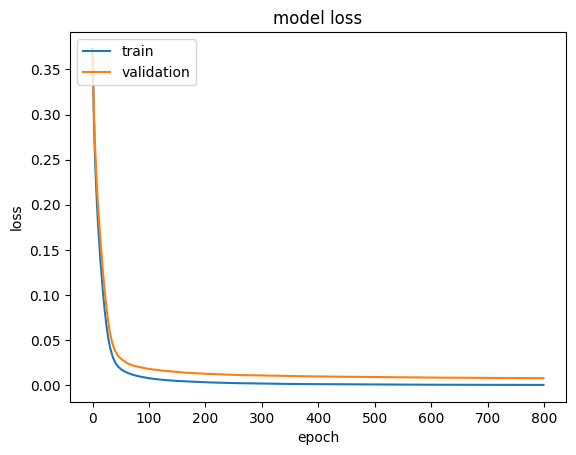

In [ ]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Predictions

So, we’ve seen how we can train a neural network model, and then validate our training data against our test data in order to determine the accuracy of our model.

However, what if we now wish to use the model to estimate unseen data?

Let’s take the following array as an example:

In [ ]:
for feature in output_features:
    print(feature)

flow_ACETIC_S1
flow_SOLVENT_S1
T_S1
flow_ACETIC_503
flow_WATER_503
T_503
CBM_total
CBM0_total
Cold_utility
Hot_utility
CO2_eq


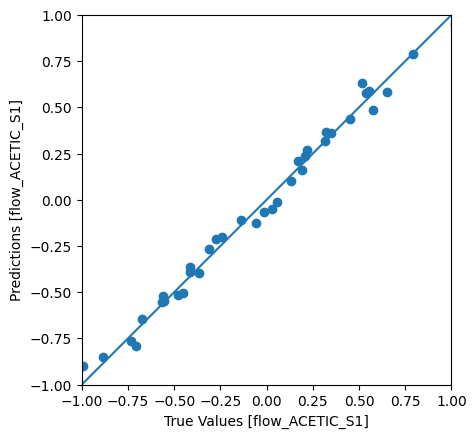

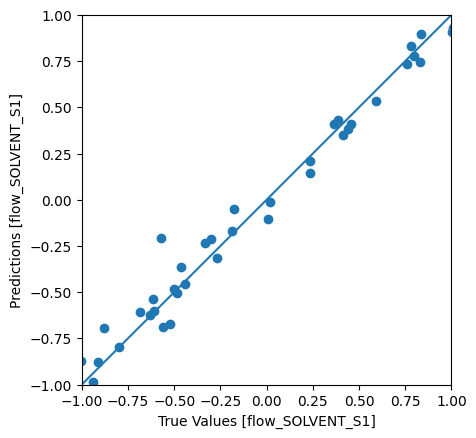

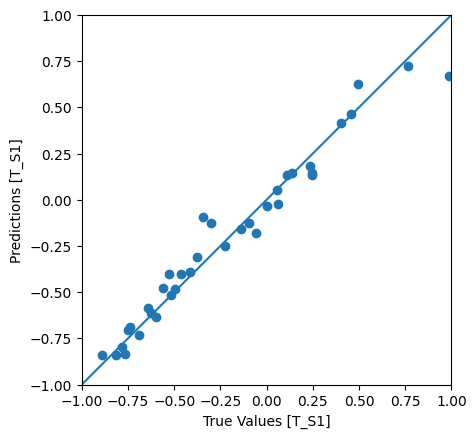

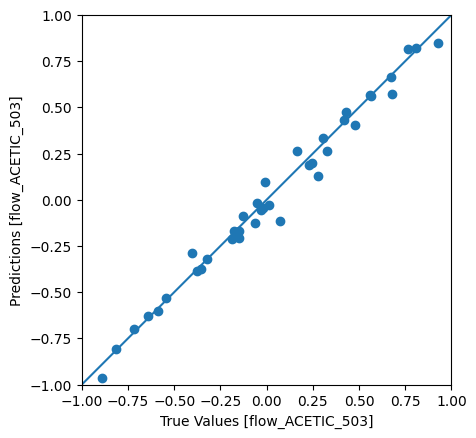

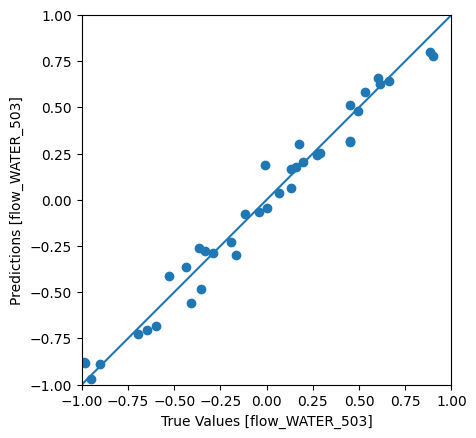

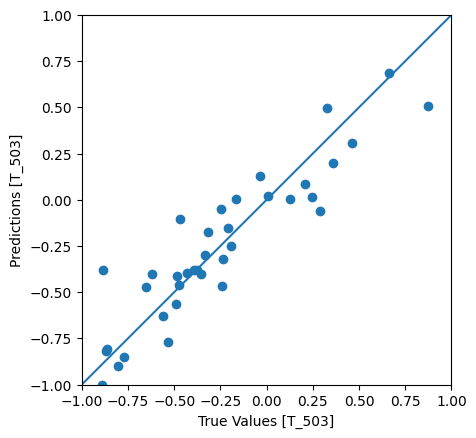

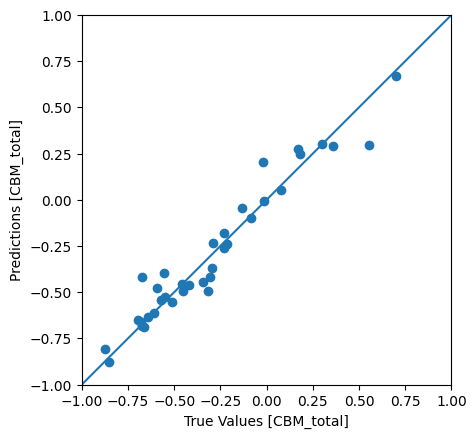

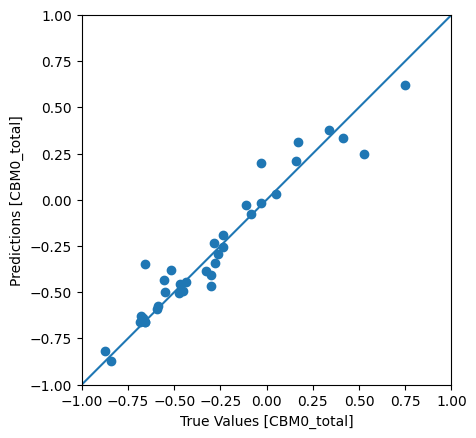

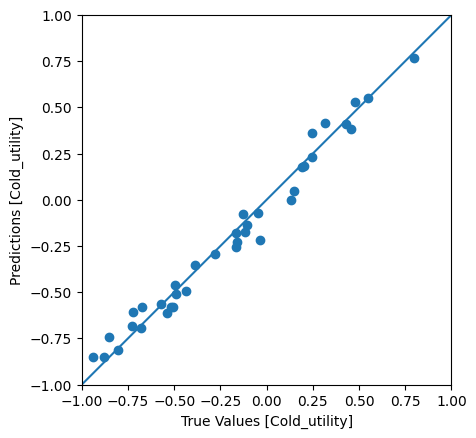

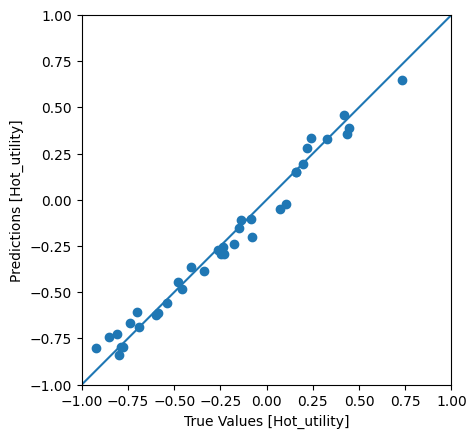

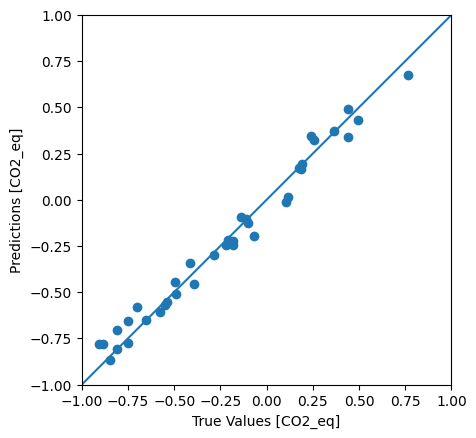

In [ ]:
i=0
for feature in output_features:
    y_pred=model.predict(X_test)
    a = plt.axes(aspect='equal')
    plt.scatter(y_test[:,i], y_pred[:,i])
    i += 1
    plt.xlabel('True Values [' + str(feature) + ']')
    plt.ylabel('Predictions [' + str(feature) + ']')
    lims = [-1, 1]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims)
    plt.show()

# Elastic Net

## Definition of the model

In [ ]:
class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = tf.keras.models.Sequential()
        model.add(
            tf.keras.layers.Dense(
                units=hp.Int('units', 10, 100, 1),
                #activation='relu',
                activation=hp.Choice(
                    'dense_activation',
                    #values=['relu'],
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu'),

                # insert the elastic net
                kernel_regularizer=tf.keras.regularizers.l1_l2(
                hp.Float(
                    'regularizer_1',
                    min_value=1e-8,
                    max_value=1e0,
                    sampling='LOG',
                    default=1e-1
                    ),
                hp.Float(
                    'regularizer_2',
                    min_value=1e-8,
                    max_value=1e0,
                    sampling='LOG',
                    default=1e-2
                    )
                ),
                input_shape=input_shape
                #kernel_initializer='GlorotNormal'
            )
        )

        model.add(tf.keras.layers.Dense(y_train.shape[1]))

        optimizer_choice = hp.Choice('optimizer', values=['adam', 'adamax', 'nadam', 'adadelta', 'rMSprop', 'adagrad'])
        if optimizer_choice == 'adam':
            hp_learning_rate = hp.Float('learning_rate', min_value=1e-8, max_value=1e0, sampling='log')
            hp_epsilon = hp.Float('epsilon', min_value=1e-8, max_value=1e0, sampling='log')
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_learning_rate, epsilon = hp_epsilon),loss='mse',metrics=['mse'] )
        elif optimizer_choice == 'adamax':
            model.compile(optimizer = tf.keras.optimizers.Adamax(learning_rate = hp.Choice('learning_rate', values = [1.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9])), loss = 'mse',metrics = ['mse'])
        elif optimizer_choice == 'nadam':
            model.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate = hp.Choice('learning_rate', values = [1.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9])), loss = 'mse',metrics = ['mse'])
        elif optimizer_choice == 'rMSprop':
            model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = hp.Choice('learning_rate', values = [1.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9])), loss = 'mse',metrics = ['mse'])
        elif optimizer_choice == 'adagrad':
            hp_learning_rate = hp.Float('learning_rate', min_value=1e-8, max_value=1e0, sampling='log')
            hp_epsilon = hp.Float('epsilon', min_value=1e-8, max_value=1e0, sampling='log')
            model.compile(optimizer = tf.keras.optimizers.Adagrad(learning_rate = hp_learning_rate, epsilon = hp_epsilon), loss = 'mse',metrics = ['mse'])
        else:
            model.compile(optimizer = tf.keras.optimizers.Adadelta(learning_rate = hp.Choice('learning_rate', values = [1.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9])), loss = 'mse',metrics = ['mse'])

        return model

model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']

## Instancie o sintonizador e execute a hiper-sintonia

In [ ]:
input_shape = (X_train.shape[1],)
hypermodel_new = RegressionHyperModel(input_shape)

Execute a pesquisa de hiperparâmetros. Os argumentos para o método de pesquisa são iguais aos usados ​​para tf.keras.model.fit , além do retorno de chamada acima.

In [ ]:
tipo = 'hyperband'
if tipo == 'bayesian':
    #https://github.com/JulieProst/keras-tuner-tutorial/blob/master/tuner_comparison.py
    tuner_bayesian= BayesianOptimization(
            hypermodel_new,
            objective='mse',
            max_trials=100, # how many model variations to test?
            executions_per_trial=1, # how many trials per variation? (same model could perform differently)
            directory='/content/drive/MyDrive/ann4a/02_Hyperparameter_Tuning/'+nome_da_corrida,
            seed=423,
            overwrite=True
        )

    tuner_bayesian.search_space_summary()
else:
      tuner_bayesian= Hyperband(
                hypermodel_new,
                max_epochs=50,
                objective='mse',
                seed=42,
                directory='/content/drive/MyDrive/ann4/02_Hyperparameter_Tuning/'+nome_da_corrida,
                executions_per_trial=2
            )
      tuner_bayesian.search_space_summary()


Search space summary
Default search space size: 7
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 100, 'step': 1, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
regularizer_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 1e-08, 'max_value': 1.0, 'step': None, 'sampling': 'log'}
regularizer_2 (Float)
{'default': 0.01, 'conditions': [], 'min_value': 1e-08, 'max_value': 1.0, 'step': None, 'sampling': 'log'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'adamax', 'nadam', 'adadelta', 'rMSprop', 'adagrad'], 'ordered': False}
learning_rate (Float)
{'default': 1e-08, 'conditions': [], 'min_value': 1e-08, 'max_value': 1.0, 'step': None, 'sampling': 'log'}
epsilon (Float)
{'default': 1e-08, 'conditions': [], 'min_value': 1e-08, 'max_value': 1.0, 'step': None, 'sampling': 'log'}


In [ ]:
if tipo == 'bayesian':
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
    tuner_bayesian.search(X_train, y_train, epochs=25, validation_split=0.15)#, callbacks=[stop_early])
else:
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
    tuner_bayesian.search(X_train, y_train, epochs=50, validation_split=0.15, callbacks=[stop_early])

Trial 90 Complete [00h 00m 08s]
mse: 0.4296891540288925

Best mse So Far: 0.008477226365357637
Total elapsed time: 00h 04m 04s


## Get the best hyperparameters

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner_bayesian.get_best_hyperparameters()[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. Regularization l1 is {best_hps.get('regularizer_1')}.
 Regularizer l2 is {best_hps.get('regularizer_2')}. The epsilon is {best_hps.get('epsilon')}
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 89 and the optimal learning rate for the optimizer
is 0.08017796013537153. Regularization l1 is 0.0005256819231240995.
 Regularizer l2 is 0.000254700927785749. The epsilon is 0.0013694484476824396



## Treine o modelo

Encontre o número ideal de épocas para treinar o modelo com os hiperparâmetros obtidos na pesquisa.

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_epoch = tuner_bayesian.hypermodel.build(best_hps)
history = model_epoch.fit(X_train, y_train, epochs=6500, validation_split=0.15)

val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch))
print('Best epoch: %d' % (best_epoch,))

A saída de streaming foi truncada nas últimas 5000 linhas.
6/6 [==============================] - 0s 7ms/step - loss: 0.0122 - mse: 0.0049 - val_loss: 0.0132 - val_mse: 0.0058
Epoch 3779/6500
6/6 [==============================] - 0s 8ms/step - loss: 0.0121 - mse: 0.0047 - val_loss: 0.0127 - val_mse: 0.0056
Epoch 3780/6500
6/6 [==============================] - 0s 7ms/step - loss: 0.0117 - mse: 0.0046 - val_loss: 0.0121 - val_mse: 0.0051
Epoch 3781/6500
6/6 [==============================] - 0s 10ms/step - loss: 0.0118 - mse: 0.0047 - val_loss: 0.0125 - val_mse: 0.0054
Epoch 3782/6500
6/6 [==============================] - 0s 7ms/step - loss: 0.0117 - mse: 0.0046 - val_loss: 0.0128 - val_mse: 0.0056
Epoch 3783/6500
6/6 [==============================] - 0s 8ms/step - loss: 0.0115 - mse: 0.0043 - val_loss: 0.0128 - val_mse: 0.0057
Epoch 3784/6500
6/6 [==============================] - 0s 7ms/step - loss: 0.0124 - mse: 0.0053 - val_loss: 0.0139 - val_mse: 0.0068
Epoch 3785/6500
6/6 [====

In [ ]:
best_epoch

3451

In [ ]:
hypermodel = tuner_bayesian.hypermodel.build(best_hps)
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.15)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
hypermodel_noepoch = tuner_bayesian.hypermodel.build(best_hps)
hypermodel_noepoch.fit(X_train, y_train, epochs=5000, callbacks=[early_stop], validation_split=0.15)

In [ ]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

eval_result = hypermodel_noepoch.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

In [ ]:
i=0
colunas = dataset.columns
input_features = colunas[0:number_of_input_variables]
output_features = colunas[number_of_input_variables:]
for feature in output_features:
    y_pred=hypermodel.predict(X_test)
    a = plt.axes(aspect='equal')
    plt.scatter(y_test[:,i], y_pred[:,i])
    i += 1
    plt.xlabel('True Values [' + str(feature) + ']')
    plt.ylabel('Predictions [' + str(feature) + ']')
    lims = [-1, 1]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot(lims, lims)
    plt.show()

In [ ]:
# Save the model as a SavedModel
hypermodel.save("/content/drive/MyDrive/ann4a/02_Hyperparameter_Tuning/Model/"+nome_da_corrida)